# Teal Carbon Wetland Scaling Analysis 

Project for UW Geospatial Data Analysis CEE498/CEWA599  
Author: Anthony Stewart 
Start date 2/23/2021


In [29]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
import rioxarray as rxr
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import mapping
import fiona

In [24]:
%matplotlib inline

# Use API to grab SRTM 30m/1 Arcsec SRTM DEM tiles for the Hoh

* https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products
* https://apps.nationalmap.gov/downloader/#/ <- this is the map view 
* https://datagateway.nrcs.usda.gov/GDGOrder.aspx <- Data gateway old site

In [3]:
#wa_bounds = (-124.733174, 45.543541, -116.915989, 49.002494)
hoh_bounds = (-124.56738280411808 , 47.581065006875235 , -123.81207274552435, 47.92637341837292)

## Use OpenTopography GlobalDEM API to fetch DEM for WA state
* OpenTopgraphy is a fantastic organization that "facilitates community access to high-resolution, Earth science-oriented, topography data, and related tools and resources."
    * https://opentopography.org/about
* One of the many services they provide is an API for several popular Global DEM datasets, with simple subsetting and delivery: https://opentopography.org/developers
* We'll use this service to extract a small portion of the SRTM-GL3 DEM

In [4]:
#List of all products hosted by OpenTopography GlobalDEM API
demtype_list = ["SRTMGL3", "SRTMGL1", "SRTMGL1_E", "AW3D30", "AW3D30_E", "SRTM15Plus"]

In [5]:
demtype = demtype_list[1]
demtype

'SRTMGL1'

> This is the 30m DEM

In [6]:
base_url="https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff"

In [7]:
base_url.format(demtype, *hoh_bounds)

'https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&west=-124.56738280411808&south=47.581065006875235&east=-123.81207274552435&north=47.92637341837292&outputFormat=GTiff'

In [8]:
def get_OT_GlobalDEM(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = '{}.tif'.format(demtype)
    
    if not os.path.exists(out_fn):
        #Prepare API request url
        #Bounds should be [minlon, minlat, maxlon, maxlat]
        url = base_url.format(demtype, *bounds) # * unpacks argument one at a time
        print(url)
        #Get
        response = requests.get(url)
        #Should check for 200
        #Write to disk
        open(out_fn, 'wb').write(response.content)

In [9]:
out_fn = f"Hoh_{demtype}.tif"
out_fn

'Hoh_SRTMGL1.tif'

In [10]:
get_OT_GlobalDEM(demtype, hoh_bounds, out_fn)

In [11]:
!ls -lah $out_fn

-rw-rw-r-- 1 jovyan users 3.6M Mar  2 05:42 Hoh_SRTMGL1.tif


In [34]:
!gdalinfo $out_fn

Driver: GTiff/GeoTIFF
Files: Hoh_SRTMGL1.tif
Size is 2719, 1243
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-124.567638888881561,47.926527777776180)
Pixel Size = (0.000277777777778,-0.000277777777778)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
  LAYOUT=COG
Corner Coordinates:
Upper Left  (-124.5676389,  47.9265278) (124d34' 3.50"W, 47d55'35.50"N)
Lower Left  (-124.5676389,  47.5812500) (124d34' 3.50"W, 47d34'52.50"N)


Open the raster file with rasterio

In [27]:
hoh_src = rxr.open_rasterio(out_fn, masked=True).squeeze()
hoh_src

<xarray.DataArray (y: 1243, x: 2719)>
[3379717 values with dtype=float64]
Coordinates:
    band         int64 1
  * y            (y) float64 47.93 47.93 47.93 47.93 ... 47.58 47.58 47.58 47.58
  * x            (x) float64 -124.6 -124.6 -124.6 ... -123.8 -123.8 -123.8
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

Coordinates:
    band         int64 1
  * y            (y) float64 47.93 47.93 47.93 47.93 ... 47.58 47.58 47.58 47.58
  * x            (x) float64 -124.6 -124.6 -124.6 ... -123.8 -123.8 -123.8
    spatial_ref  int64 0

[Text(0.5, 1.0, 'Hoh SRTM DEM')]

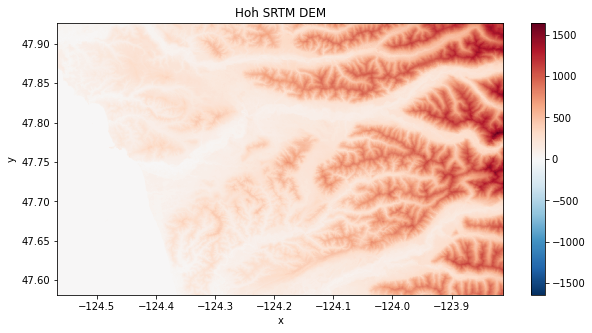

In [28]:
f, ax = plt.subplots(figsize=(10, 5))
hoh_src.plot.imshow()
ax.set(title="Hoh SRTM DEM")

# Find and grab shapefile for the Hoh to use for clipping

<AxesSubplot:>

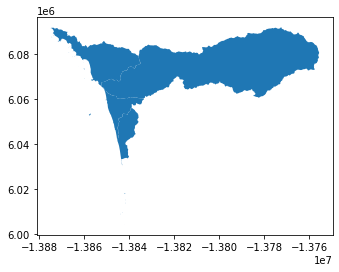

In [19]:
#For now...
hoh_shp_fn = '../gda_teal_carbon/hoh_shape/hoh_watershed_clip.shp'
hoh_shp = gpd.read_file(hoh_shp_fn)
hoh_geom = hoh_shp.geometry
hoh_geom.plot()

<AxesSubplot:>

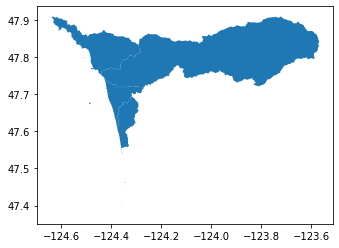

In [40]:
hoh_geom = hoh_geom.to_crs('EPSG:4326')
hoh_geom.plot()

-124.56738280411808 	  Ymin = 47.581065006875235 	  Xmax = -123.81207274552435 	  Ymax = 47.92637341837292# Need to merge SRTM DEMs together

# Clip the DEMs by the Hoh shapefile

In [41]:
hoh_clipped = hoh_src.rio.clip(hoh_geom.geometry.apply(mapping),
                                      # This is needed if your GDF is in a diff CRS than the raster data
                                      hoh_geom.crs)

[Text(0.5, 1.0, 'Raster Layer Cropped to Geodataframe Extent')]

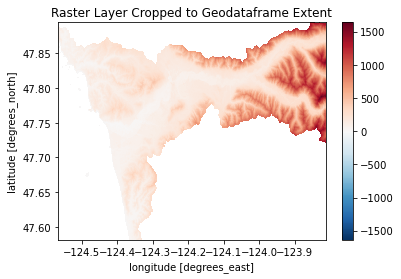

In [44]:
f, ax = plt.subplots()
hoh_clipped.plot(ax=ax)
ax.set(title="Raster Layer Cropped to Geodataframe Extent")


# This might be where ArcGIS is needed to generate DEM metrics (slope, catchment, curvature, etc.) and to get the model output

# Import in raster files for all metrics and the model output

# Import the point data for the Carbon Stocks

In [17]:
hohpts_fn = '../gda_teal_carbon/hoh_sample_datasheet_2020.csv'
hohpts_df = pd.read_csv(hohpts_fn)
hohpts_gdf = gpd.GeoDataFrame(hohpts_df, crs='EPSG:4326', geometry=gpd.points_from_xy(hohpts_df['lon'], hohpts_df['lat']))

In [18]:
hohpts_gdf

,sample name,c_stock_g_cm2,full_horiz_c_stock,WIP,w_or_u,lat,lon,geometry
0,W Hoh Oxbow,0.057251,0.928835,0.855,w,47.810750,-124.260700,POINT (-124.26070 47.81075)
1,E-ML-FR-H-1040,0.530333,6.987945,0.075,w,47.778390,-124.116967,POINT (-124.11697 47.77839)
2,Hoh-ML-FR-1008.1,0.918214,4.041169,0.105,u,47.797501,-124.188779,POINT (-124.18878 47.79750)
3,Hoh-ML-NE-FR-1043,2.967889,7.803837,0.270,w,47.787200,-124.110355,POINT (-124.11035 47.78720)
4,S-Hoh-ML-FR-1200,0.645896,1.289509,0.365,u,47.789367,-124.166635,POINT (-124.16664 47.78937)
5,N-Up-Hoh-MC,0.110212,1.767975,0.755,u,47.821061,-124.042698,POINT (-124.04270 47.82106)
6,N-Mid-Hoh-MC,0.034643,1.191331,0.010,w,47.813808,-124.129756,POINT (-124.12976 47.81381)


# Extract data from the around the point data 
* Look at Friedrich's links in Slack
* Try different methods of extraction (Nearest Neighbor, etc.)